# Load Everything

In [18]:
import functools
import json
import os
from typing import Any, List, Tuple, Union
import einops
import matplotlib.pyplot as plt
import torch
import torch as t
import torch.nn.functional as F
from fancy_einsum import einsum
from sklearn.linear_model import LinearRegression
from torch import nn
from toy_transformer import ParenTransformer, SimpleTokenizer
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import train_test_split

plt.rcParams.update({'font.size': 22})

MAIN = __name__ == "__main__"
device = "cuda"
IS_CI = os.getenv("IS_CI")

In [17]:
model = ParenTransformer(ntoken=5, nclasses=2, d_model=56, nhead=2, d_hid=56, nlayers=3).to(device)
state_dict = t.load("w2d3_state_dict.pt")
model.to(device)
model.load_simple_transformer_state_dict(state_dict)
model.eval()
tokenizer = SimpleTokenizer("()")
with open("w2d3_data.json") as f:
    data_tuples: List[Tuple[str, bool]] = json.load(f)
    print(f"loaded {len(data_tuples)} examples")
assert isinstance(data_tuples, list)


class DataSet:
    """A dataset containing sequences, is_balanced labels, and tokenized sequences"""

    def __init__(self, data_tuples: list):
        """
        data_tuples is List[Tuple[str, bool]] signifying sequence and label
        """
        self.strs = [x[0] for x in data_tuples]
        self.isbal = t.tensor([x[1] for x in data_tuples]).to(device=device, dtype=t.bool)
        self.toks = tokenizer.tokenize(self.strs).to(device)

        self.open_proportion = t.tensor([s.count("(") / len(s) for s in self.strs])
        self.starts_open = t.tensor([s[0] == "(" for s in self.strs]).bool()

    def __len__(self) -> int:
        return len(self.strs)

    def __getitem__(self, idx) -> Union["DataSet", tuple[str, t.Tensor, t.Tensor]]:
        if type(idx) == slice:
            return self.__class__(list(zip(self.strs[idx], self.isbal[idx])))
        return self.strs[idx], self.isbal[idx], self.toks[idx]

    @property
    def seq_length(self) -> int:
        return self.toks.size(-1)

    @classmethod
    def with_length(cls, data_tuples: list[tuple[str, bool]], selected_len: int) -> "DataSet":
        return cls([(s, b) for (s, b) in data_tuples if len(s) == selected_len])

    @classmethod
    def with_start_char(cls, data_tuples: list[tuple[str, bool]], start_char: str) -> "DataSet":
        return cls([(s, b) for (s, b) in data_tuples if s[0] == start_char])


# N_SAMPLES = 5000 if not IS_CI else 100
data_tuples = data_tuples
data = DataSet(data_tuples)

def run_model_on_data(model: ParenTransformer, data: DataSet, batch_size: int = 2000) -> t.Tensor:
    """Return probability that each example is balanced"""
    ln_probs = []
    for i in range(0, len(data.strs), batch_size):
        toks = data.toks[i : i + batch_size]
        # note model outputs in a weird shape, [seqlen, batch, 2 (unbal, bal)]
        with t.no_grad():
            out = model(toks)
        ln_probs.append(out)
    out = t.cat(ln_probs).exp()
    assert out.shape == (len(data), 2)
    return out

def get_inputs(model: ParenTransformer, data: DataSet, module: nn.Module) -> t.Tensor:
    """
    Get the inputs to a particular submodule of the model when run on the data.
    Returns a tensor of size (data_pts, seq_pos, emb_size).
    """
    "SOLUTION"
    acts = []
    fn = lambda m, i, o: acts.append(i[0].detach().clone())
    h = module.register_forward_hook(fn)
    run_model_on_data(model, data)
    h.remove()
    out = t.concat(acts, dim=0)
    assert out.shape == (len(data), data.seq_length, model.d_model)
    return out.clone()


def get_outputs(model: ParenTransformer, data: DataSet, module: nn.Module) -> t.Tensor:
    """
    Get the outputs from a particular submodule of the model when run on the data.
    Returns a tensor of size (data_pts, seq_pos, emb_size).
    """
    "SOLUTION"
    acts = []
    fn = lambda m, i, o: acts.append(o.detach().clone())
    h = module.register_forward_hook(fn)
    run_model_on_data(model, data)
    h.remove()
    out = t.concat(acts, dim=0)
    assert out.shape == (len(data), data.seq_length, model.d_model)
    return out.clone()

def get_out_by_head(model: ParenTransformer, data: DataSet, layer: int) -> t.Tensor:
    """
    Get the output of the heads in a particular layer when the model is run on the data.
    Returns a tensor of shape (batch, num_heads, seq, embed_width)
    """

    "SOLUTION"
    out_proj: nn.Linear = model.layers[layer].self_attn.project_output
    combined_values = get_inputs(model, data, out_proj).to(device)
    num_heads = model.nhead
    # pytorch stores weight matricies in shape [out_features, in_features]
    o_mats_by_head = einops.rearrange(out_proj.weight, " out (head head_size) -> out head head_size", head=num_heads)
    head_value = einops.rearrange(combined_values, "b seq (head head_size)-> b seq head head_size", head=num_heads)
    out_by_head = einsum(
        "out head head_size, batch seq head head_size -> batch head seq out",
        o_mats_by_head,
        head_value,
    )
    assert out_by_head.shape == (len(data), num_heads, data.seq_length, model.d_model)
    return out_by_head.clone()

loaded 100000 examples


# Probing for Proportion of Left vs Right Parens

In [36]:
# with t.inference_mode():
#     head_all = get_out_by_head(model, data, 0).cpu().numpy()
is_left = t.sum(data.toks == 3, dim=1)
is_right = t.sum(data.toks == 4, dim=1)
equal_num = ((is_left - is_right)/(is_left + is_right)).cpu().numpy()

LINEAR TRAIN SCORE:  0.9551706321992708
LINEAR TEST SCORE:  0.955145817928084
LOGISTIC TRAIN SCORE:  0.9872444444444445
LOGISTIC TEST SCORE:  0.9876
LOGISTIC TRAIN SCORE:  0.9676222222222223
LOGISTIC TEST SCORE:  0.9694
LINEAR TRAIN SCORE:  0.9435256543396914
LINEAR TEST SCORE:  0.9435812906902427
LOGISTIC TRAIN SCORE:  0.9494888888888889
LOGISTIC TEST SCORE:  0.9492


/home/ubuntu/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LOGISTIC TRAIN SCORE:  0.9590555555555556
LOGISTIC TEST SCORE:  0.959
LINEAR TRAIN SCORE:  0.9600056000931713
LINEAR TEST SCORE:  0.9617854085802823
LOGISTIC TRAIN SCORE:  0.9982111111111112
LOGISTIC TEST SCORE:  0.9982
LOGISTIC TRAIN SCORE:  0.9984888888888889
LOGISTIC TEST SCORE:  0.9979
LINEAR TRAIN SCORE:  0.8960147945344735
LINEAR TEST SCORE:  0.8958441133438443
LOGISTIC TRAIN SCORE:  0.9602666666666667
LOGISTIC TEST SCORE:  0.9634
LOGISTIC TRAIN SCORE:  0.9618444444444444
LOGISTIC TEST SCORE:  0.9624
LINEAR TRAIN SCORE:  0.8905058301587434
LINEAR TEST SCORE:  0.8907581148539299
LOGISTIC TRAIN SCORE:  0.9799222222222223
LOGISTIC TEST SCORE:  0.9804


/home/ubuntu/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LOGISTIC TRAIN SCORE:  0.9834888888888889
LOGISTIC TEST SCORE:  0.9847
LINEAR TRAIN SCORE:  0.8701950413130511
LINEAR TEST SCORE:  0.8671674745419735


/home/ubuntu/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LOGISTIC TRAIN SCORE:  0.9693555555555555
LOGISTIC TEST SCORE:  0.9683
LOGISTIC TRAIN SCORE:  0.9727444444444444
LOGISTIC TEST SCORE:  0.9743
LINEAR TRAIN SCORE:  0.8912591568644487
LINEAR TEST SCORE:  0.8898240747572941


/home/ubuntu/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LOGISTIC TRAIN SCORE:  0.9624777777777778
LOGISTIC TEST SCORE:  0.9669


/home/ubuntu/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LOGISTIC TRAIN SCORE:  0.9646222222222223
LOGISTIC TEST SCORE:  0.9638
LINEAR TRAIN SCORE:  0.8790406531493743
LINEAR TEST SCORE:  0.8790655730253336


/home/ubuntu/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LOGISTIC TRAIN SCORE:  0.9576222222222223
LOGISTIC TEST SCORE:  0.9568


/home/ubuntu/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LOGISTIC TRAIN SCORE:  0.9562111111111111
LOGISTIC TEST SCORE:  0.9573
LINEAR TRAIN SCORE:  0.8291152008300583
LINEAR TEST SCORE:  0.8189977706941032
LOGISTIC TRAIN SCORE:  0.9743
LOGISTIC TEST SCORE:  0.9754
LOGISTIC TRAIN SCORE:  0.9656444444444444
LOGISTIC TEST SCORE:  0.9668
LINEAR TRAIN SCORE:  0.8021327902607378
LINEAR TEST SCORE:  0.7999467163999732
LOGISTIC TRAIN SCORE:  0.9565666666666667
LOGISTIC TEST SCORE:  0.953
LOGISTIC TRAIN SCORE:  0.9491111111111111
LOGISTIC TEST SCORE:  0.9496
LINEAR TRAIN SCORE:  0.7874075740822123
LINEAR TEST SCORE:  0.7857796233426995
LOGISTIC TRAIN SCORE:  0.9272555555555556
LOGISTIC TEST SCORE:  0.9253
LOGISTIC TRAIN SCORE:  0.9665
LOGISTIC TEST SCORE:  0.9643
LINEAR TRAIN SCORE:  0.8659042919842109
LINEAR TEST SCORE:  0.8620951392863777
LOGISTIC TRAIN SCORE:  0.9645444444444444
LOGISTIC TEST SCORE:  0.9639
LOGISTIC TRAIN SCORE:  0.9590444444444445
LOGISTIC TEST SCORE:  0.9609


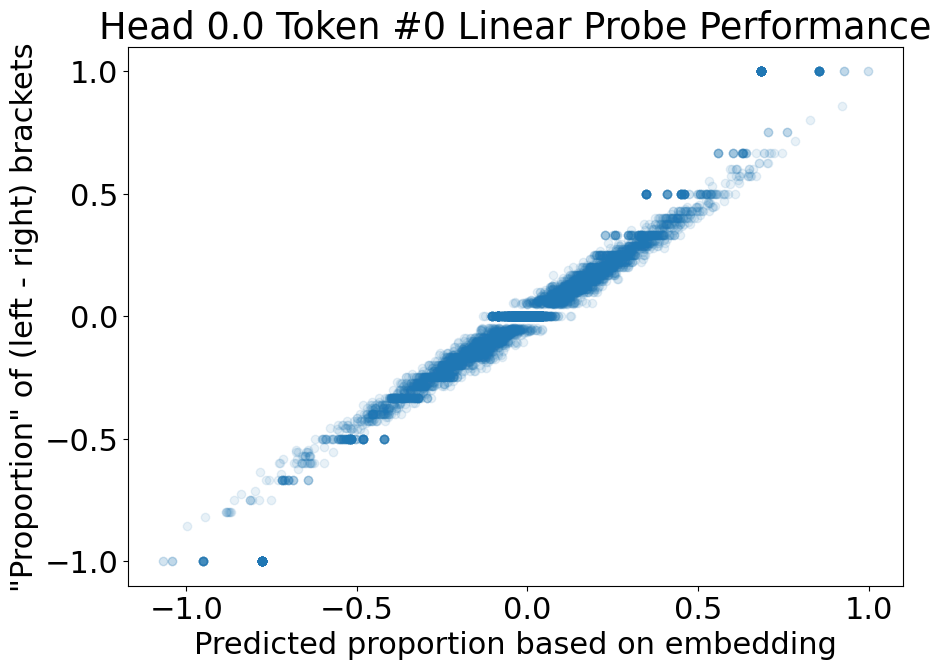

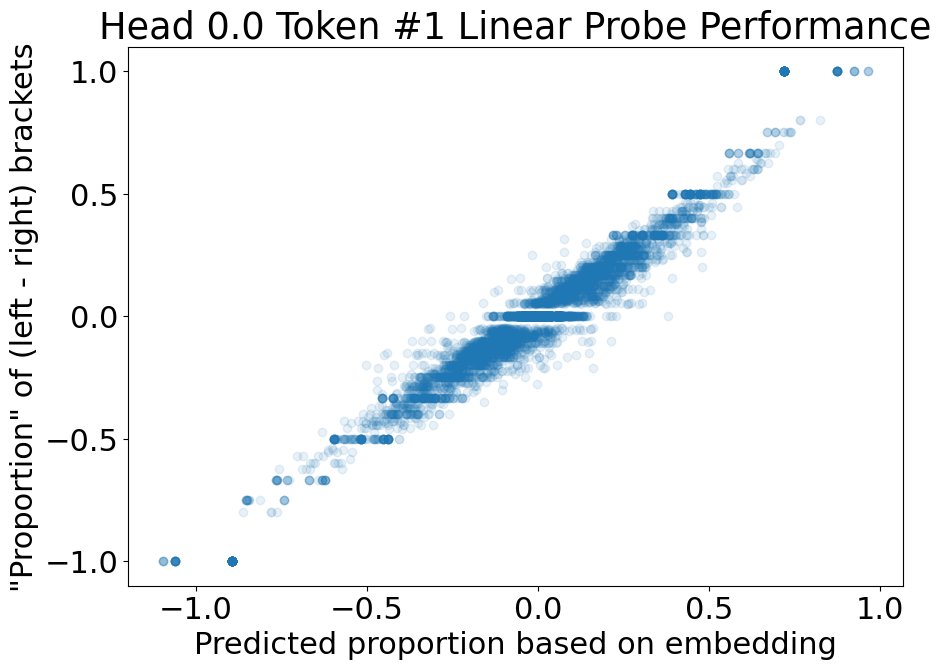

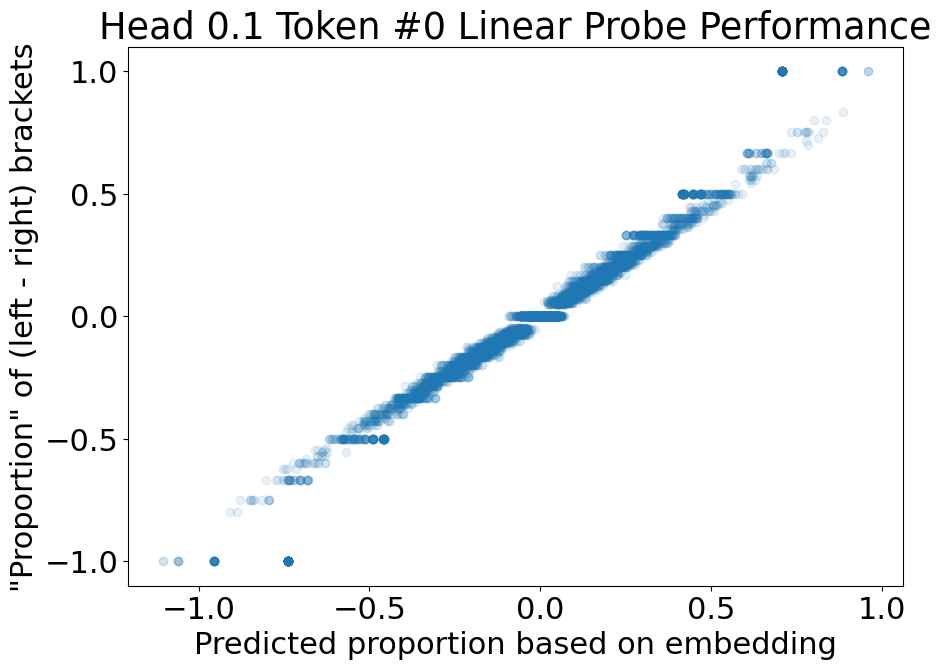

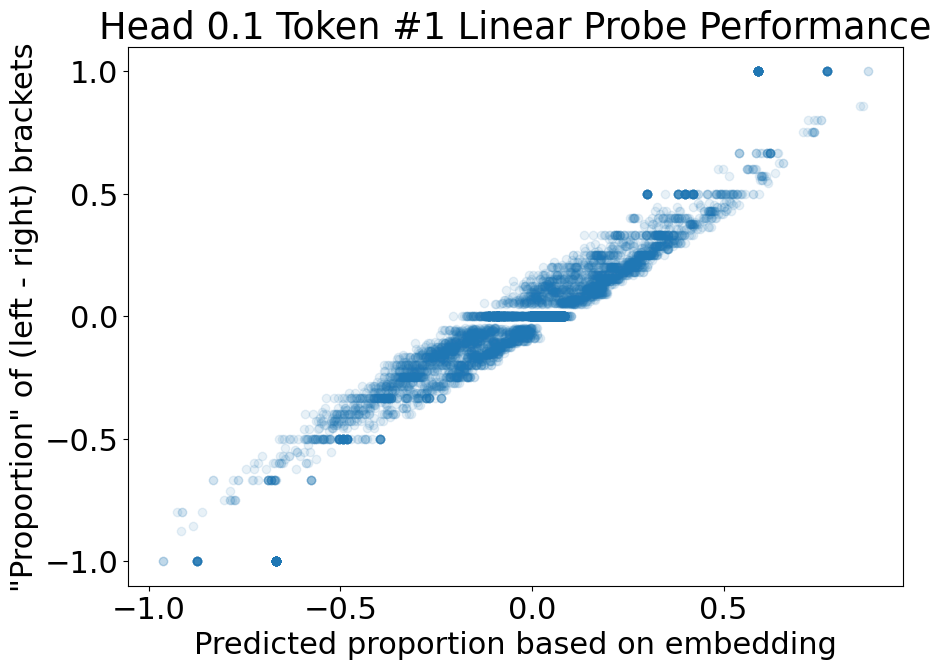

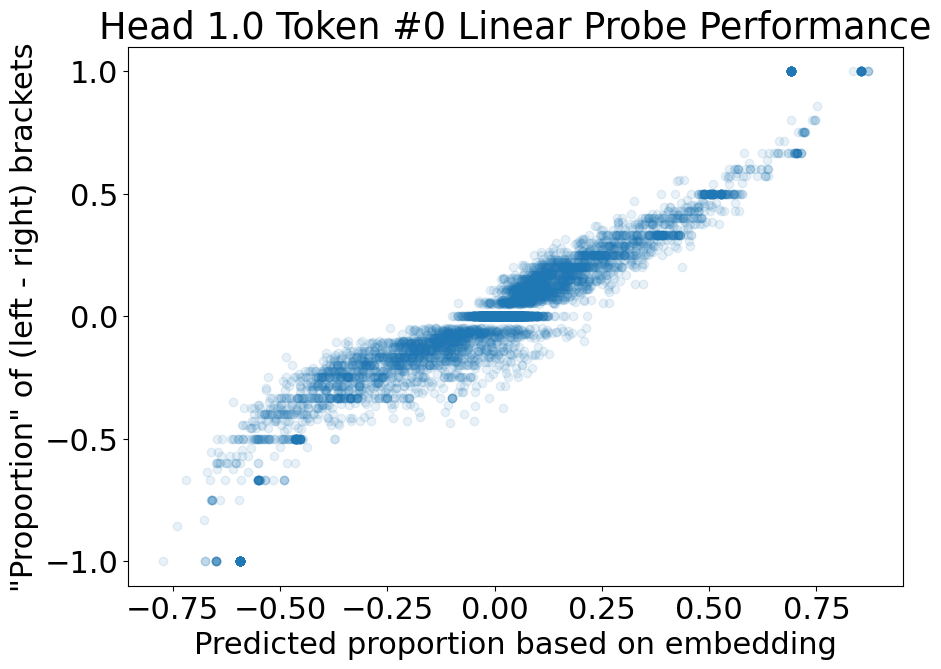

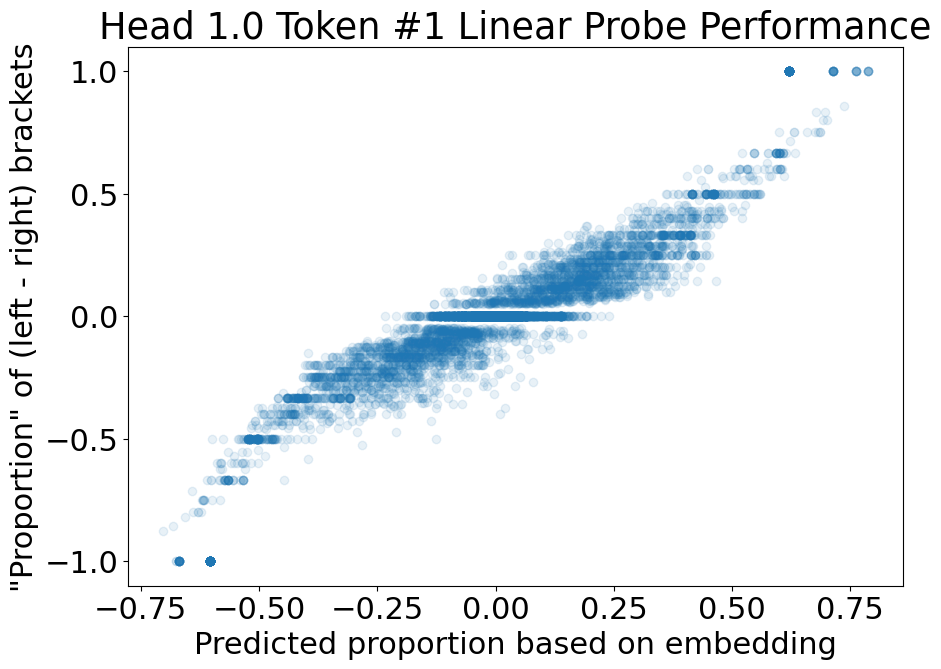

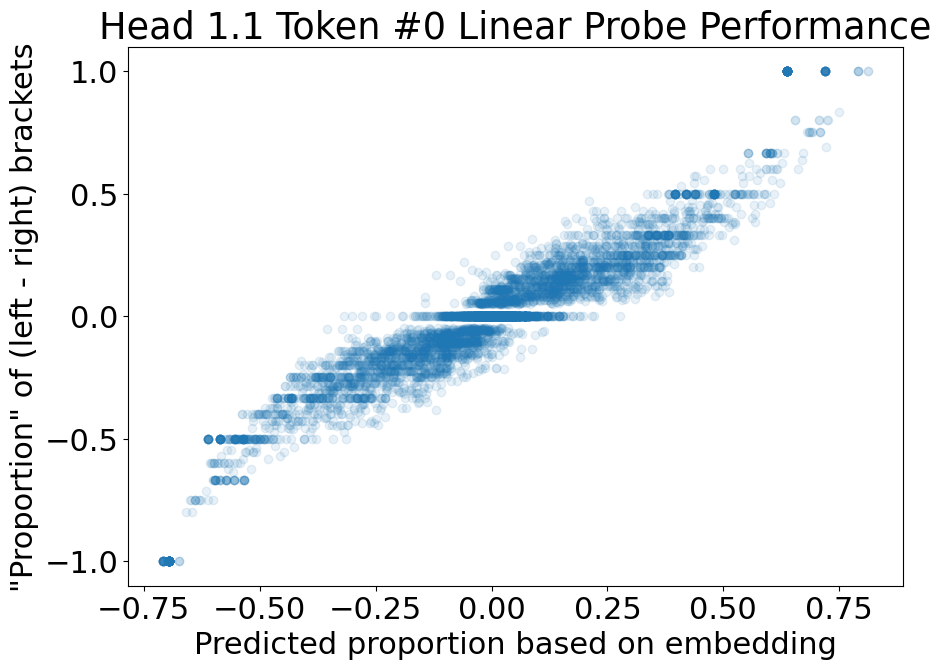

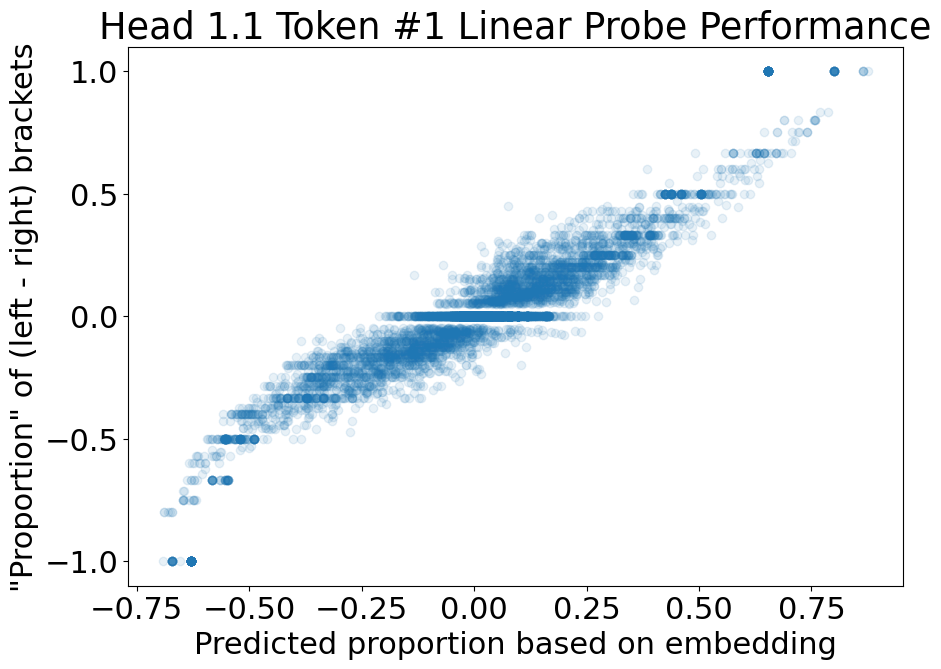

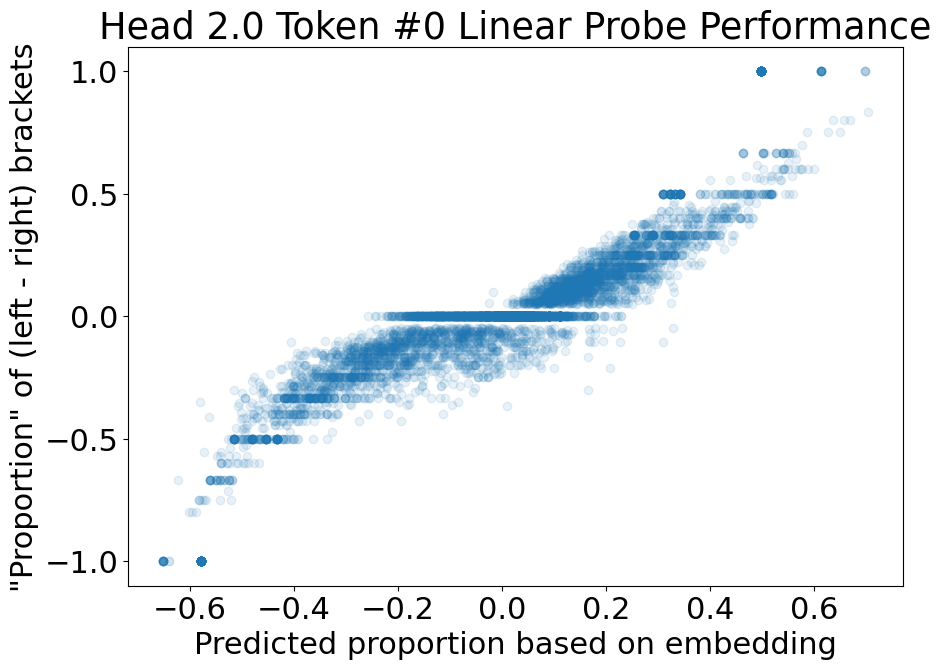

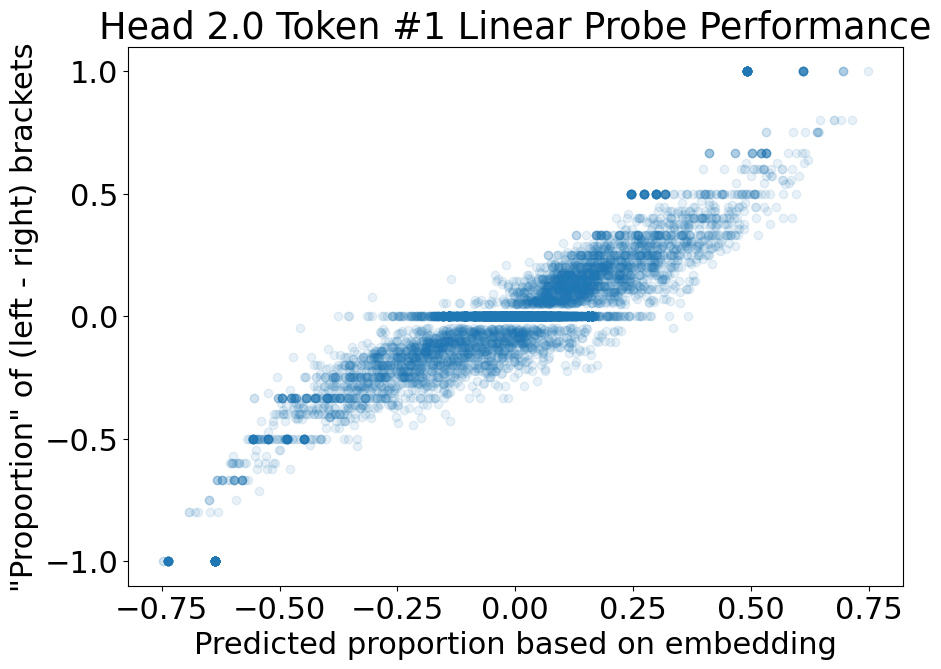

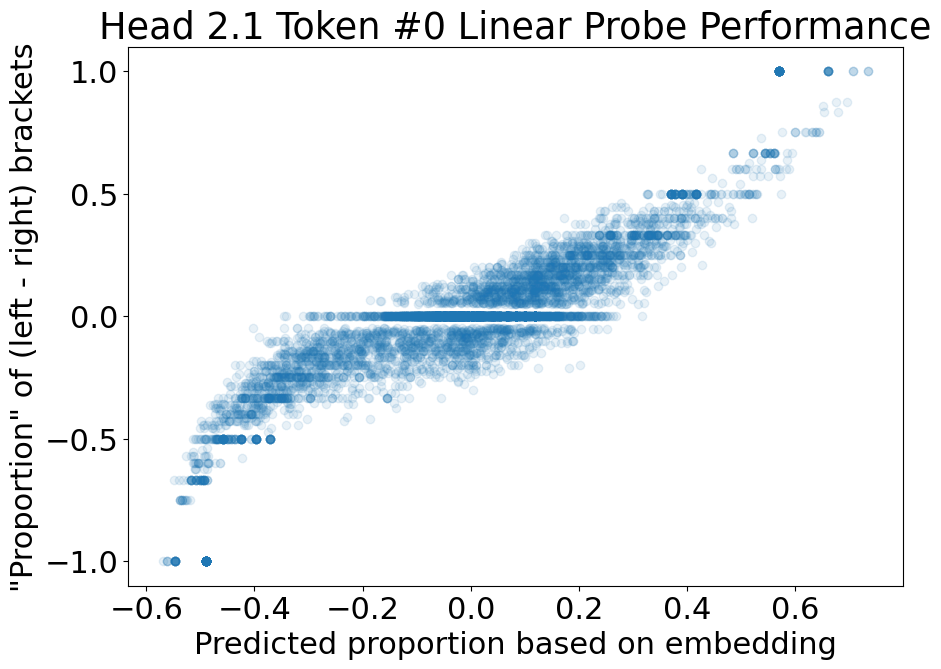

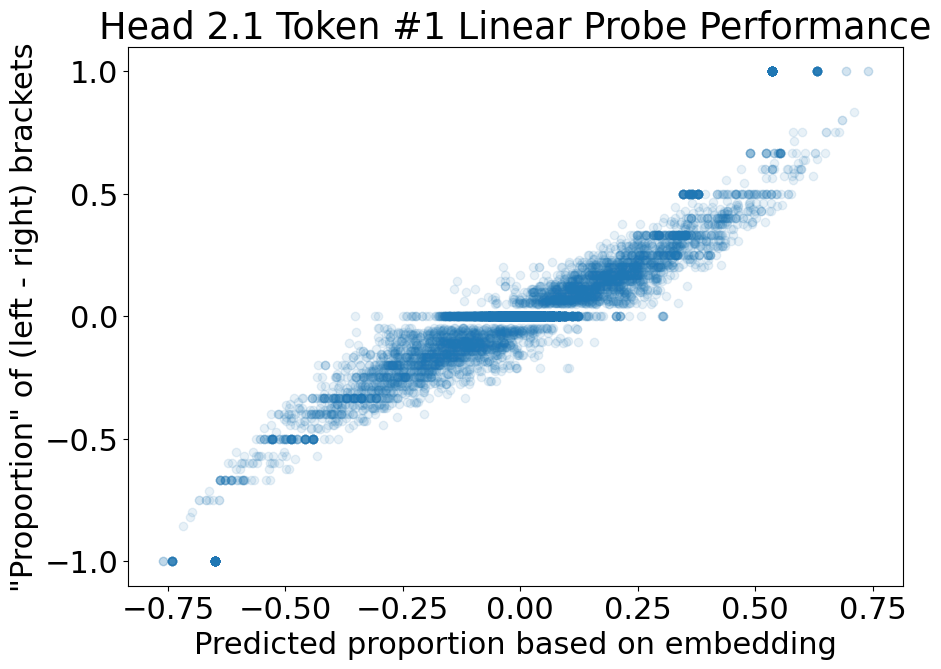

In [37]:
linear_scores = np.zeros((3, 2, 2))
linear_coefs = np.zeros((3, 2, 2, 56))
logistic_scores_less0 = np.zeros((3, 2, 2))
logistic_scores_more0 = np.zeros((3, 2, 2))

with t.inference_mode():
    
    for layer in range(3):

        head_all = get_out_by_head(model, data, layer).cpu().numpy()

        for head in range(2):

            for token in range(2):

                head_train, head_test, equal_num_train, equal_num_test = train_test_split(head_all[:, head, token], equal_num, test_size=0.1)

                linear = Ridge(alpha=0.1)
                fitted_linear = linear.fit(head_train, equal_num_train)
                print("LINEAR TRAIN SCORE: ", fitted_linear.score(head_train, equal_num_train))
                linear_scores[layer][head][token] = fitted_linear.score(head_test, equal_num_test)
                print("LINEAR TEST SCORE: ", linear_scores[layer][head][token])
                linear_coefs[layer][head][token] = fitted_linear.coef_

                logistic = LogisticRegression()
                fitted_logistic = logistic.fit(head_train, equal_num_train > 0)
                print("LOGISTIC TRAIN SCORE: ", fitted_logistic.score(head_train, equal_num_train > 0))
                logistic_scores_more0[layer][head][token] = fitted_logistic.score(head_test, equal_num_test > 0)
                print("LOGISTIC TEST SCORE: ", logistic_scores_more0[layer][head][token])

                logistic = LogisticRegression()
                fitted_logistic = logistic.fit(head_train, equal_num_train < 0)
                print("LOGISTIC TRAIN SCORE: ", fitted_logistic.score(head_train, equal_num_train < 0))
                logistic_scores_less0[layer][head][token] = fitted_logistic.score(head_test, equal_num_test < 0)
                print("LOGISTIC TEST SCORE: ", logistic_scores_less0[layer][head][token])

                plt.figure(figsize=(10, 7))
                plt.scatter(fitted_linear.predict(head_test), equal_num_test, alpha=0.1)
                plt.ylabel("\"Proportion\" of (left - right) brackets")
                plt.xlabel("Predicted proportion based on embedding")
                plt.title(f"Head {layer}.{head} Token #{token} Linear Probe Performance")

Text(0, 0.5, 'Token #')

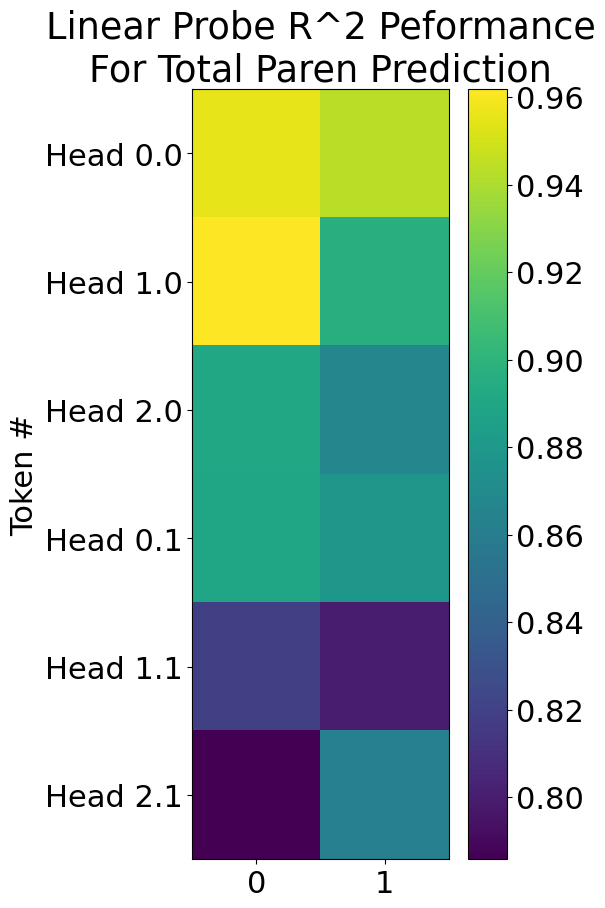

In [49]:
plt.figure(figsize=(5, 10))
plt.imshow(linear_scores.reshape(-1, 2))
plt.yticks(range(6), [f"Head {layer}.{head}"for head in range(2) for layer in range(3)])
plt.colorbar()
plt.title("Linear Probe R^2 Peformance\nFor Total Paren Prediction")
plt.ylabel("Token #")

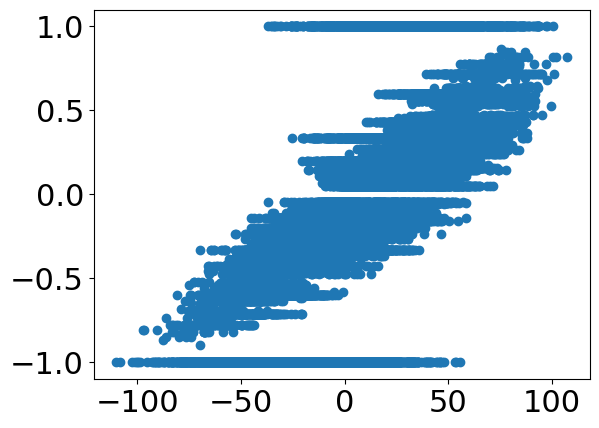

In [27]:
index = 20

is_left = t.sum(data.toks[:, index:] == 3, dim=1)
is_right = t.sum(data.toks[:, index:] == 4, dim=1)
equal_num = ((is_left - is_right)/(is_left + is_right)).cpu().numpy()

paren_emb = np.array([-0.22606339, -0.3817214, -1.4104964, 0.19177942, 1.9899428, 0.4391564, 0.7656387, -0.63001657, 1.2170641, -0.78435856, -2.0772018, 0.5796861, 0.14452729, -1.5480461, -1.4717238, 1.3908799, -2.650712, 2.2939675, 1.9186023, 2.2521715, -0.97538763, -2.0912004, -2.1513553, 1.0542943, -1.6433673, -0.49036485, 1.5739079, -1.6167231, 0.005950656, -0.5535703, -1.6153314, 0.34630018, -1.2608914, 2.3687954, -2.0325658, 2.681696, 1.3179133, 0.21228376, 0.2400737, 2.4026039, -0.22275975, -1.6459382, 0.49807006, 0.4056123, 0.574695, 0.31673485, -1.1493986, 1.0393034, 0.48291945, 1.7879814, 0.32313624, -0.44806415, 1.7664179, 1.3369981, 0.039000615, 0.7465193])
dot_scores = np.dot(head_all[:, 0, index], paren_emb[:, None])[:, 0]
plt.scatter(dot_scores, equal_num)